In [376]:
#importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
# import lazypredict

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")

import statsmodels.tsa.stattools as st
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA

In [377]:
df_ger = pd.read_csv('Data/Germany.csv',  index_col='Year')
df_ger # the one with categorical variable for Germany

,Country,ISO 3166-1 alpha-3,Total,Coal,Oil,Gas
Year,,,,,,
1980,Brazil,BRA,185.471117,19.986728,150.210064,1.883259
1981,Brazil,BRA,170.613975,19.723312,135.527696,1.685440
1982,Brazil,BRA,170.811520,21.551648,133.193728,2.381600
1983,Brazil,BRA,165.348839,23.926447,125.740255,3.378282
1984,Brazil,BRA,167.076404,28.996896,122.062496,4.169632
1985,Brazil,BRA,179.589112,34.870994,127.517108,4.994133
1986,Brazil,BRA,196.613291,35.123104,142.375712,5.986976
1987,Brazil,BRA,205.332593,40.234384,145.541408,6.639168
1988,Brazil,BRA,207.069970,39.776384,147.651872,6.840688


In [378]:
# Drop the categorial variables
df= df_ger.select_dtypes(include=['float64'])
df

,Total,Coal,Oil,Gas
Year,,,,
1980,185.471117,19.986728,150.210064,1.883259
1981,170.613975,19.723312,135.527696,1.685440
1982,170.811520,21.551648,133.193728,2.381600
1983,165.348839,23.926447,125.740255,3.378282
1984,167.076404,28.996896,122.062496,4.169632
1985,179.589112,34.870994,127.517108,4.994133
1986,196.613291,35.123104,142.375712,5.986976
1987,205.332593,40.234384,145.541408,6.639168
1988,207.069970,39.776384,147.651872,6.840688


In [379]:
#  plot to see total emission versus year for 'Germany'
fig_ger = px.line(df, x=df.index, y="Total")
fig_ger.update_xaxes(rangeslider_visible=True)
fig_ger.show()

Visualize the time series

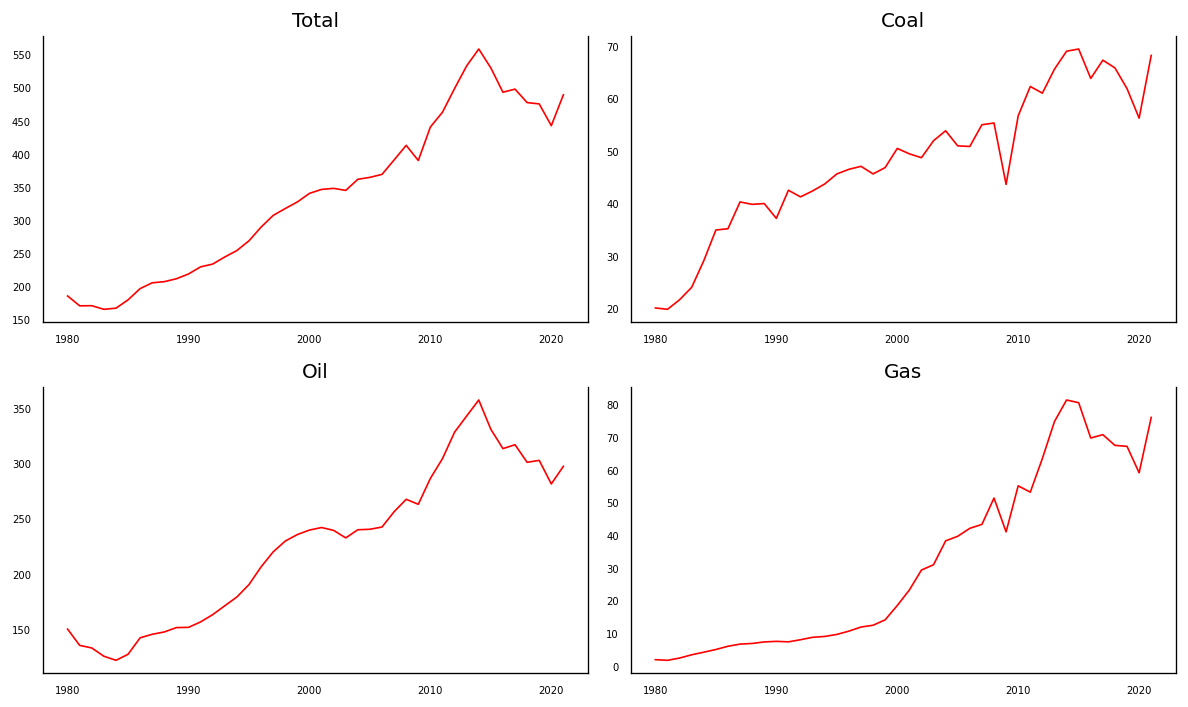

In [380]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

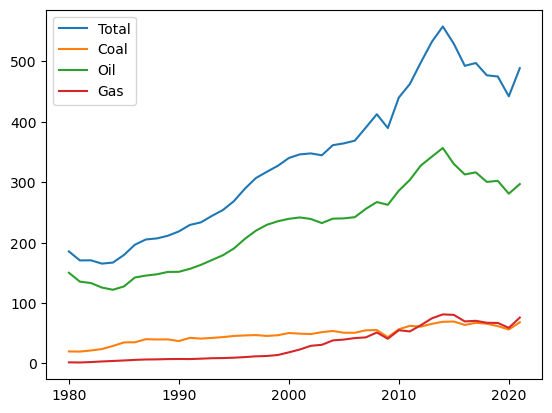

In [381]:
plt.figure()

x = df.index
y1 = df['Total']
y2 = df['Coal']
y3 = df['Oil']
y4 = df['Gas']






plt.plot(x,y1)
plt.plot(x,y2)
plt.plot(x,y3)
plt.plot(x,y4)




plt.legend(['Total', 'Coal', 'Oil', 'Gas'])

Grainger's Causality Test

In [382]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)   

,Total_x,Coal_x,Oil_x,Gas_x
Total_y,1.0,0.0,0.0,0.0
Coal_y,0.0,1.0,0.0,0.0
Oil_y,0.0,0.0,1.0,0.0
Gas_y,0.0,0.0,0.0,1.0


 Cointegration Test

In [383]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Total  ::  88.1      > 40.1749   =>   True
Coal   ::  43.68     > 24.2761   =>   True
Oil    ::  11.59     > 12.3212   =>   False
Gas    ::  0.05      > 4.1296    =>   False
